# Reuters News Headlines 2012-17 Analysis

In [100]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
from sklearn import preprocessing
import ast
import glob
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb
from wordcloud import WordCloud
%matplotlib inline

### Read all the CSV files and concatinate in one dataframe

In [5]:
path =r'RawData' # importing the raw data
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
df = pd.concat(list_)

In [42]:
df[:5]

,publish_time,headline_text
0,201201010005,Leap Year 2012 Calls for 'One More Disney Day'...
1,201201010014,MSG Leaves Time Warner Cable Sports Fans in th...
2,201201010040,Box Office - 'M - I - 4' Passes $100M Domestic...
3,201201010048,New York New Year
4,201201010053,Number of Ion Community Users Triples; Spurred...


### Removing unwanted characters

In [48]:
df1 = df.dropna()

In [51]:
df1[:5]

,publish_time,headline_text
0,201201010005,Leap Year 2012 Calls for 'One More Disney Day'...
1,201201010014,MSG Leaves Time Warner Cable Sports Fans in th...
2,201201010040,Box Office - 'M - I - 4' Passes $100M Domestic...
3,201201010048,New York New Year
4,201201010053,Number of Ion Community Users Triples; Spurred...


### Seperating out the publish_time to date and time

In [55]:
df1['published_date'] = df1['publish_time'].astype(str).str[:8]

C:\Users\Mitesh.Puthran\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [64]:
df1['published_time'] = df1['publish_time'].astype(str).str[-4:]

C:\Users\Mitesh.Puthran\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [65]:
df1[:5]

,publish_time,headline_text,published_date,published_time
0,201201010005,Leap Year 2012 Calls for 'One More Disney Day'...,20120101,0005
1,201201010014,MSG Leaves Time Warner Cable Sports Fans in th...,20120101,0014
2,201201010040,Box Office - 'M - I - 4' Passes $100M Domestic...,20120101,0040
3,201201010048,New York New Year,20120101,0048
4,201201010053,Number of Ion Community Users Triples; Spurred...,20120101,0053


In [67]:
df1['published_date'] = pd.to_datetime(df1['published_date'])

C:\Users\Mitesh.Puthran\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [75]:
df1['published_time'] = pd.to_datetime(df1['published_time'], unit='s').dt.time

C:\Users\Mitesh.Puthran\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [77]:
del df1['publish_time']

,headline_text,published_date,published_time
0,Leap Year 2012 Calls for 'One More Disney Day'...,2012-01-01,00:00:05
1,MSG Leaves Time Warner Cable Sports Fans in th...,2012-01-01,00:00:14
2,Box Office - 'M - I - 4' Passes $100M Domestic...,2012-01-01,00:00:40
3,New York New Year,2012-01-01,00:00:48
4,Number of Ion Community Users Triples; Spurred...,2012-01-01,00:00:53


### Finding the most used common words in headlines other than 'the', 'a' etc.

In [94]:
df1['headline_text'] = df1['headline_text'].str.lower().replace('[^A-Za-z\s<>]+', '')

C:\Users\Mitesh.Puthran\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [113]:
df1[:5]

,headline_text,published_date,published_time
0,leap year 2012 calls for 'one more disney day'...,2012-01-01,00:00:05
1,msg leaves time warner cable sports fans in th...,2012-01-01,00:00:14
2,box office - 'm - i - 4' passes $100m domestic...,2012-01-01,00:00:40
3,new york new year,2012-01-01,00:00:48
4,number of ion community users triples; spurred...,2012-01-01,00:00:53


In [165]:
df1.dtypes

headline_text             object
published_date    datetime64[ns]
published_time            object
dtype: object

In [166]:
words = df1['headline_text']
frequency={}
for w in words:
    if w.isalpha(): # to check whether the word list consists of all alphabets
        if w not in frequency:
            frequency[w] = 1  #initial frequency of the word
        else:
            frequency[w] += 1 # for existing words, increment by 1
                
freqwords=sorted(frequency.items(),  key=lambda x: x[1], reverse=True) # using sorted function to sort the words 
print("Words with the highest frequency are : ")
freqwords

Words with the highest frequency are : 


[('counterparties', 18),
 ('newmarketcorporationdeclaresquarterlydividend', 2),
 ('test', 2),
 ('welcome', 2),
 ('manhattanhenge', 2),
 ('sikanews', 2),
 ('flirt', 1),
 ('wikiyawn', 1),
 ('shipbreakers', 1),
 ('advisory', 1),
 ('feisal', 1),
 ('boeasing', 1),
 ('delisting', 1),
 ('revolution', 1),
 ('shakedown', 1),
 ('qumureleaseshybridcloudvideocommunicationssolution', 1),
 ('rehabilitation', 1),
 ('tba', 1),
 ('yes', 1),
 ('inflationumberitis', 1),
 ('sanctuary', 1),
 ('wonkonomics', 1),
 ('malariasucks', 1),
 ('clarification', 1),
 ('oktoberfest', 1),
 ('pesticideland', 1),
 ('vocareum', 1),
 ('marlins', 1),
 ('testsrts', 1)]

In [118]:
del df1['headline_length']

### Finding most number of headlines with certain number of words

In [175]:
count = df1['headline_text'].str.split().apply(len).value_counts()
count.index = 'Headlines with ' + count.index.astype(str) + ' words:'
count[:10]

Headlines with 9 words:     613454
Headlines with 10 words:    583534
Headlines with 8 words:     507817
Headlines with 11 words:    457269
Headlines with 7 words:     341509
Headlines with 12 words:    337849
Headlines with 13 words:    228901
Headlines with 6 words:     196580
Headlines with 14 words:    162414
Headlines with 15 words:    121935
Name: headline_text, dtype: int64

In [178]:
type(count)

pandas.core.series.Series

### The graph shows that most healines in dataset had 9 words.

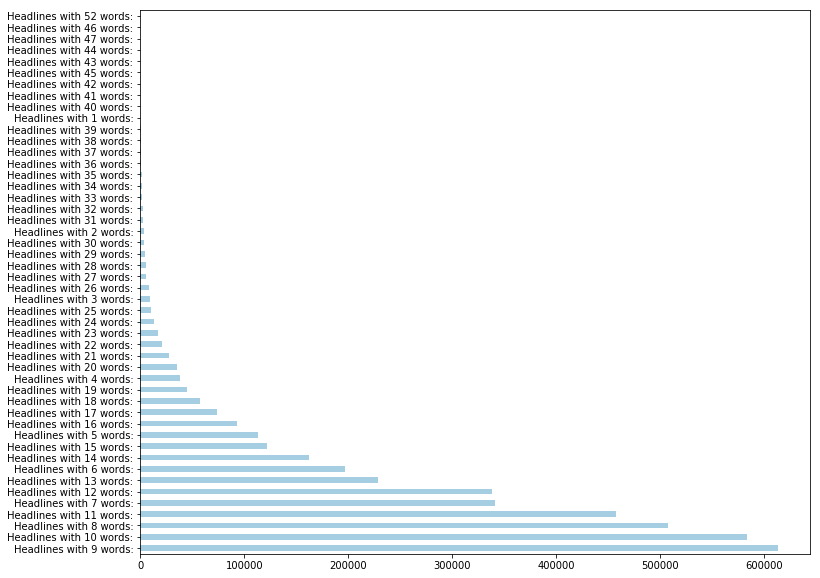

In [176]:
%matplotlib inline
a = count.plot(kind='barh', colormap='Paired'); #selecting the type of bargraph to display
fig = a.get_figure()
fig.set_size_inches(12, 10)

### Finding the most used words in the headlines with wordcloud

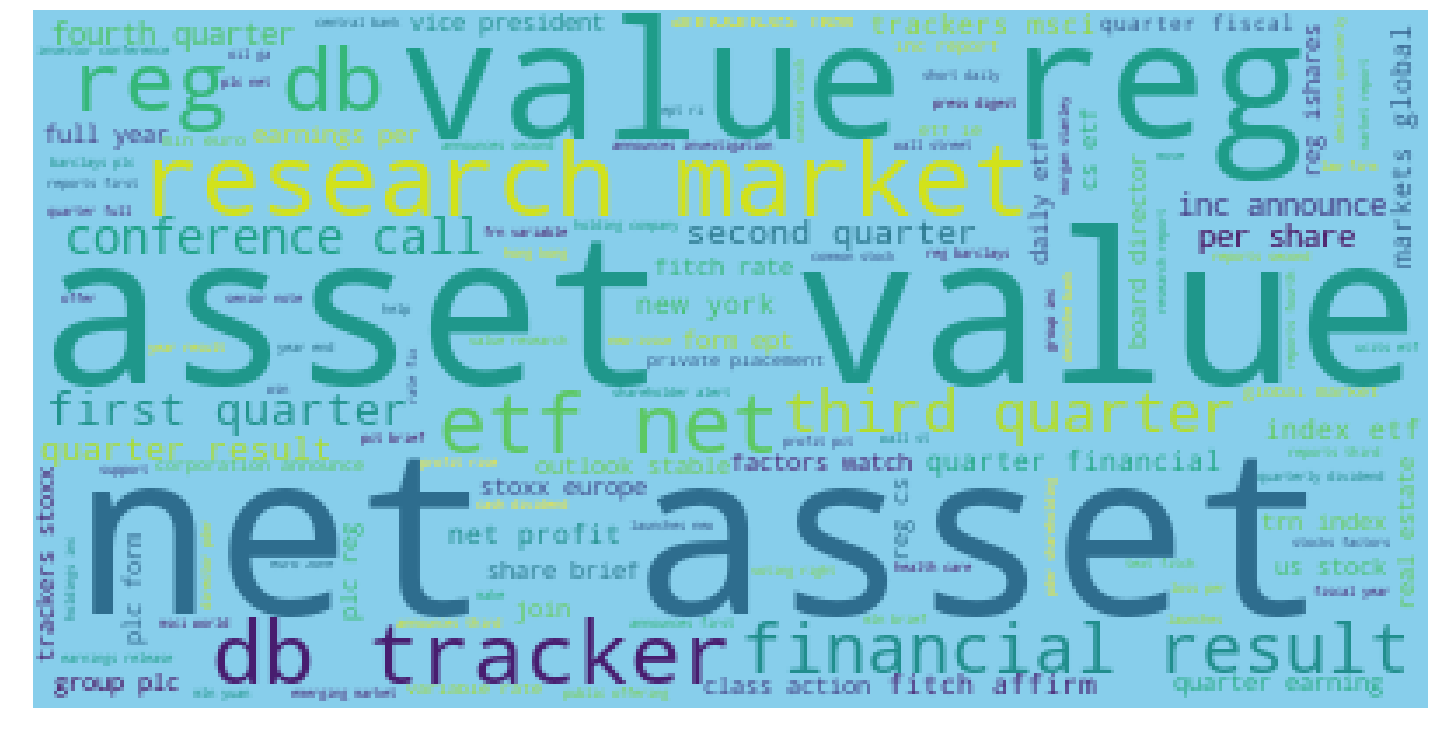

In [180]:
wordcloud =  WordCloud(background_color="skyblue").generate(' '.join(df1['headline_text']))
# Generate plot
plt.figure( figsize=(25,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

### Defining functions to classify the news headlines belonging to different topics using LDA

In [145]:
def get_keys(topic_matrix):
    '''returns an integer list of predicted topic categories for a given topic matrix'''
    keys = []
    for i in range(topic_matrix.shape[0]):
        keys.append(topic_matrix[i].argmax())
    return keys

def keys_to_counts(keys):
    '''returns a tuple of topic categories and their accompanying magnitudes for a given list of keys'''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [146]:
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''returns a list of n_topic strings, where each string contains the n most common 
        words in a predicted category, in order'''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [159]:
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''returns a list of centroid vectors from each predicted topic category'''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [198]:
n_topics = 20

### Testing out vectorization on the small sample (10000 news headlines) of data

In [152]:
reindexed_data = df1['headline_text']
reindexed_data.index = df1['published_date']
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = reindexed_data.sample(n=10000, random_state=0).as_matrix()

print('Headline before vectorization: ', small_text_sample[123])

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Headline after vectorization: \n', small_document_term_matrix[123])

Headline before vectorization:  bihua environmental engineering is the first in china to roll out a line of nano photocatalyst air purification products
Headline after vectorization: 
   (0, 12555)	1
  (0, 12757)	1
  (0, 1007)	1
  (0, 12036)	1
  (0, 10777)	1
  (0, 9422)	1
  (0, 13695)	1
  (0, 5603)	1
  (0, 2199)	1
  (0, 5661)	1
  (0, 3379)	1


### Applying LDA

In [199]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [200]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [201]:
top_n_words_lda = get_top_n_words(2, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i), top_n_words_lda[i])

Topic 0:  present ceo
Topic 1:  update fund
Topic 2:  brief reg
Topic 3:  brief announces
Topic 4:  new says
Topic 5:  preview dividend
Topic 6:  rate reg
Topic 7:  research markets
Topic 8:  china shares
Topic 9:  brief profit
Topic 10:  new program
Topic 11:  business technology
Topic 12:  stocks india
Topic 13:  bank national
Topic 14:  launches deal
Topic 15:  quarter results
Topic 16:  fitch outlook
Topic 17:  reg asset
Topic 18:  new high
Topic 19:  update announces


Text(0.5,1,'LDA Topic Category Counts')

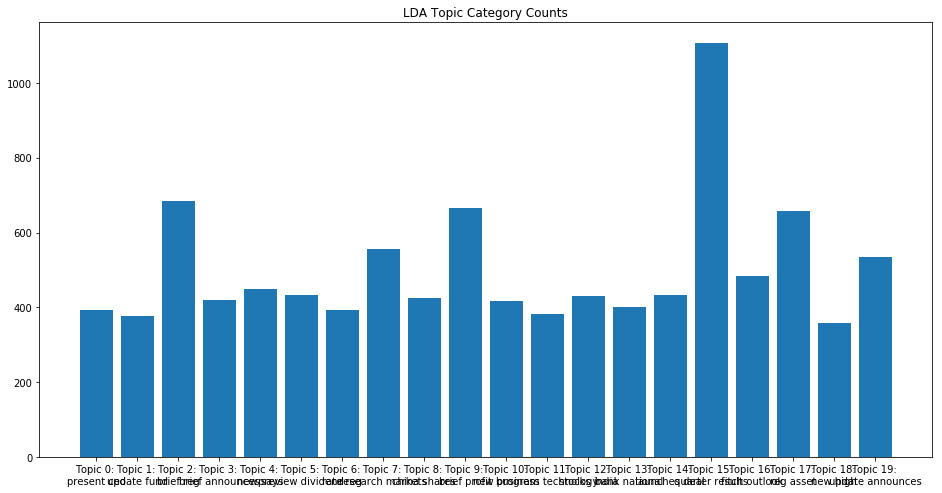

In [202]:
top_2_words = get_top_n_words(2, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_2_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts)
ax.set_xticks(lda_categories)
ax.set_xticklabels(labels)
ax.set_title('LDA Topic Category Counts')

### Using t-SNE to get better classification among the topics

In [157]:
from sklearn.manifold import TSNE

tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=10, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.048s...
[t-SNE] Computed neighbors for 10000 samples in 13.579s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.087745
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.277466
[t-SNE] Error after 2000 iterations: 1.732939


### Plotting the different cluster topics that were discovered

In [161]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

Loading BokehJS ...

In [162]:
top_2_words_lda = get_top_n_words(2, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_2_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

C:\Users\Mitesh.Puthran\AppData\Local\Continuum\anaconda3\lib\site-packages\bokeh\core\json_encoder.py:80: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(type(obj), np.float):


### Scaling up to the whole dataset to find out the different clusters

In [203]:
big_sample_size = 4000000 

big_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
big_text_sample = reindexed_data.sample(n=big_sample_size, random_state=0).as_matrix()
big_document_term_matrix = big_count_vectorizer.fit_transform(big_text_sample)

big_lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', verbose=1)
big_lda_model.fit(big_document_term_matrix)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=20, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

In [204]:
yearly_data = []
for i in range(2012,2017+1):
    yearly_data.append(reindexed_data['{}'.format(i)].as_matrix())

yearly_topic_matrices = []
for year in yearly_data:
    document_term_matrix = big_count_vectorizer.transform(year)
    topic_matrix = big_lda_model.transform(document_term_matrix)
    yearly_topic_matrices.append(topic_matrix)

yearly_keys = []
for topic_matrix in yearly_topic_matrices:
    yearly_keys.append(get_keys(topic_matrix))
    
yearly_counts = []
for keys in yearly_keys:
    categories, counts = keys_to_counts(keys)
    yearly_counts.append(counts)

yearly_topic_counts = pd.DataFrame(np.array(yearly_counts), index=range(2012,2017+1))
yearly_topic_counts.columns = ['Topic {}'.format(i) for i in range(n_topics)]

print(yearly_topic_counts)

      Topic 0  Topic 1  Topic 2  Topic 3  Topic 4  Topic 5  Topic 6  Topic 7  \
2012    50151    57126    41801    54225    40931    38641    79506    61888   
2013    44341    42523    39251    31755    34867    38051    34092    37569   
2014    32091    47766    27215    38716    38108    49870    35590    35891   
2015    43891    31073    40524    29866    37341    27375    48900    34302   
2016    32766    12727     9916    11161    29203    60524    30154    16519   
2017    20143    13650    12812    16079    13541    25857    11577    12521   

      Topic 8  Topic 9  Topic 10  Topic 11  Topic 12  Topic 13  Topic 14  \
2012    47501    33986     49275     32361     33560     48487     38454   
2013    27970    56205     46193     29005     39583     29696     27090   
2014    35525    37820     35077     41422     32544     35626     28928   
2015    40679    33730     58922     39739     72035     38035     28937   
2016     2452    13529     16126     10701     16408     20

In [205]:
complete_keys = [key for year in yearly_keys for key in year]
complete_topic_matrix = np.vstack(yearly_topic_matrices)
complete_document_term_matrix = big_count_vectorizer.transform(reindexed_data.as_matrix())

top_n_words = get_top_n_words(2, complete_keys, complete_document_term_matrix, big_count_vectorizer)

for i in range(len(top_n_words)):
    print('Topic {}: '.format(i), top_n_words[i])

Topic 0:  group announces
Topic 1:  business press
Topic 2:  research markets
Topic 3:  global state
Topic 4:  says brief
Topic 5:  announces agreement
Topic 6:  preview rate
Topic 7:  reg plc
Topic 8:  new power
Topic 9:  chief new
Topic 10:  fitch outlook
Topic 11:  deal russia
Topic 12:  brief mln
Topic 13:  reg asset
Topic 14:  quarter results
Topic 15:  announces brief
Topic 16:  update bln
Topic 17:  2014 credit
Topic 18:  dividend year
Topic 19:  media uk


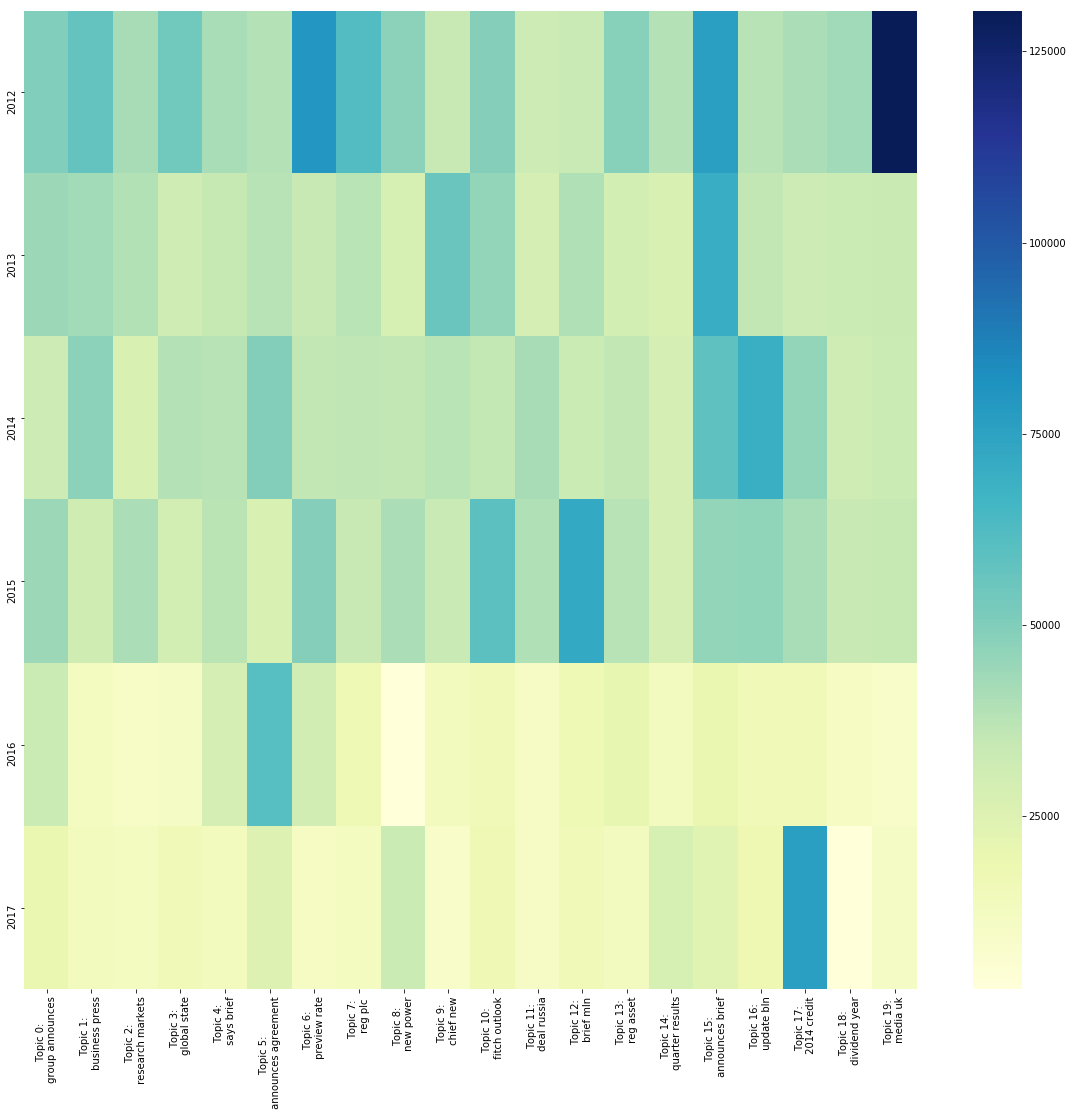

In [206]:
labels = ['Topic {}: \n '.format(i) + ' '.join([topic.split() for topic in top_n_words][i][:3]) for i in range(n_topics)]

fig, ax = plt.subplots(figsize=(20,18))
sb.heatmap(yearly_topic_counts, xticklabels=labels, cmap="YlGnBu", ax=ax)